In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import datetime
import psycopg2
from sqlalchemy import create_engine
import sqlalchemy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
projects = ['p50_david_dietz_2020','p50_hao_chen_2020','p50_hao_chen_2020_rnaseq','p50_paul_meyer_2020',
            'u01_olivier_george_cocaine', 'u01_olivier_george_oxycodone', 'u01_olivier_george_scrub',
            'u01_peter_kalivas_italy', 'u01_peter_kalivas_us', 'u01_suzanne_mitchell', 'u01_tom_jhou' ]
def runQuery(query):

    cursor = connection.cursor()
    if "SELECT" in query:
        table = pd.read_sql(query, con = connection)
    elif "UPDATE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    elif "DELETE" in query:
        cursor.execute(query)
        print(query)
        connection.commit()
    else:
        return None
    if connection:
        cursor.close()
        connection.close()
        if "SELECT" in query:
            return table
        else:
            return
#change project here
current_project = projects[8]
data = runQuery("SELECT * FROM " + current_project + ".wfu_master")
data = data.replace('nan', np.nan)


In [3]:
#Check column headers
#if there is a non'normal' column header make note of it
#if one of the normal column headers is missing make note of it
def column_qc():
    print("Column headers for: "+ current_project)
    for column in data.columns:
        print(column)
    common_headers = ['cohort','sires','dames','labanimalid','accessid','sex','rfid','dob','dow','shipmentdate',
                      'litternumber','littersize','coatcolor','earpunch','rack','shipmentbox','shipmentage','weanage',
                      'comments','resolution']
    #find any odd column headers
    for column in data.columns:
        if column not in common_headers:
            print("\nNon uniform column headers:")
            print(column)
    for column in common_headers:
        if column not in data.columns:
            print("\nMissing uniform column header:")
            print(column)
column_qc()

Column headers for: u01_peter_kalivas_us
cohort
sires
dames
labanimalid
accessid
sex
rfid
dob
dow
shipmentdate
litternumber
littersize
coatcolor
earpunch
rack
shipmentbox
shipmentage
weanage
comments
resolution


In [4]:
#count the numbe of unique rfid in sheet
len(data.rfid.unique())

640

In [5]:
#data = data.fillna(value=np.nan)


In [6]:
#Calculate the weanage based on dob and dow and compare to weanage given in table
#data[['dob','dow','weanage']]
data['calculated_weanage'] = (data['dow'] - data['dob']).dt.days
#data[['calculated_weanage']]
print('Incorrect Wean Age:')
incorrect_weanage = data.loc[~(data['calculated_weanage'] == data['weanage'])]
incorrect_weanage = incorrect_weanage.astype(str)
#drop values where no weanage was able to be calculated
incorrect_weanage = incorrect_weanage[incorrect_weanage.calculated_weanage != 'nan']
incorrect_weanage

Incorrect Wean Age:


,cohort,sires,dames,labanimalid,accessid,sex,rfid,dob,dow,shipmentdate,...,littersize,coatcolor,earpunch,rack,shipmentbox,shipmentage,weanage,comments,resolution,calculated_weanage


In [7]:
data.weanage.value_counts()

21.0    515
20.0     56
22.0     46
23.0     23
Name: weanage, dtype: int64

In [8]:
#Update Weanage in data base


def update_weanage():
    table_name = "p50_paul_meyer_2020.wfu_master"
    for index,row in incorrect_weanage.iterrows():
    #df.set_index('dob').to_dict()['dow']
        query = "UPDATE " + table_name
        query = query + " SET " + "weanage = " + row['calculated_weanage']
        query = query + " WHERE " + "rfid = '"+ row['rfid'] + "'" 
        #print(query)
        runQuery(query)
#update_weanage()
#UPDATE ... SET weanage = row["calculated_weanage"] WHERE rfid = row["rfid"]

In [9]:
#calculate the shipment age based on dob and shipmentdate then compare to shipment age given
data['calculated_shipage'] = (data['shipmentdate'] - data['dob']).dt.days
data[['calculated_shipage']]
incorrect_shipmentage = data.loc[~(data['calculated_shipage'] == data['shipmentage'])].dropna()
print('Incorrect Shipment Age:')
incorrect_shipmentage

Incorrect Shipment Age:


,cohort,sires,dames,labanimalid,accessid,sex,rfid,dob,dow,shipmentdate,...,coatcolor,earpunch,rack,shipmentbox,shipmentage,weanage,comments,resolution,calculated_weanage,calculated_shipage


Number of cohorts for u01_peter_kalivas_us:


16

Cohorts for u01_peter_kalivas_us and the number of subjects in each:


C01    40
C02    40
C03    40
C04    40
C05    40
C06    40
C07    40
C08    40
C09    40
C10    40
C11    40
C12    40
C13    40
C14    40
C15    40
C16    40
Name: cohort, dtype: int64

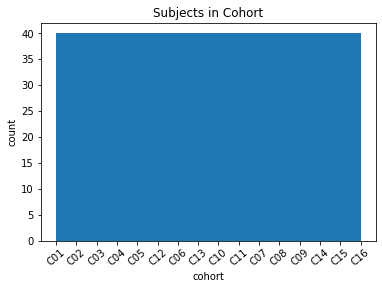

In [10]:
#Check the amount of subjects in each cohort
#order_bin = pd.value_counts(data['cohort']).sort_index().index

def cohorts(data):
    print("Number of cohorts for " + current_project + ":")
    display(len(data['cohort'].value_counts().sort_index()))
    print("Cohorts for " + current_project + " and the number of subjects in each:")
    display(data['cohort'].value_counts().sort_index())
    bins = len(data['cohort'].unique())
    

    plt.title('Subjects in Cohort')
    plt.xlabel('cohort')
    plt.ylabel('count')
    plt.xticks(rotation = 40)
    plt.hist(data['cohort'], bins = bins)    
    plt.show() 
cohorts(data)

In [11]:
#count the number of sires and dames in each cohort
#count how many of those sires and dames are unique meaning that multiple sires and dames had more than one child
#check how many parent pairs there are
#Check how many parent pairs are present in multiple cohorts
#check if there is an rfid labeled as both a sire and a dame
def qc_pedigree(data):
    sires = list(data["sires"])
    dames = list(data["dames"])
    
    data = data.sort_values(["cohort", "labanimalid"])

    # Printing number of mothers and fathers per cohort
    unique_sires = []
    unique_dames = []
    for cohort in np.unique(data["cohort"]):
        subset = data[data["cohort"] == cohort]
        sires = list(subset["sires"])
        dames = list(subset["dames"])
        unique_sires.append(len(set(sires)))
        unique_dames.append(len(set(dames)))
        print(cohort, "sires", "total", len(sires), "unique", len(set(sires)))
        print(cohort, "dames", "total", len(dames), "unique", len(set(dames)))
#     plot_list = {'Sires':unique_sires,'Dames':unique_dames}
#     bins = len(data['cohort'].unique())
#     for name,value in plot_list.items():
#         plt.title(name)
#         plt.xlabel('unique subjects')
#         plt.ylabel('count')
#         plt.xticks(rotation = 40)
#         plt.hist(value, bins = bins)    
#         plt.show()
    # Printing animals listed as mother and father

    #print("sires", len(set(sires)), "dames", len(set(dames)), "overlap", len(overlap))

    # Checking sibling numbers
    parents_dict = {}
    parents_litter_birth = {}
    dob = []
    litter = []
    parents_df = pd.DataFrame()
    for index, row in data.iterrows():
        parents = (row["sires"], row["dames"])
        
        if parents in parents_dict.keys():
            parents_dict[parents].append(row["rfid"])
            parents_litter_birth[parents].append(row["dob"])
        else:
            dob.append(row['dob'])
            litter.append(row['littersize'])
            parents_dict[parents] = [row["rfid"]]
            parents_litter_birth[parents] = [row["dob"]]
            parents_df = parents_df.append({'sires':row["sires"],'dames':row["dames"]},ignore_index = True)
    print("\nparent pairs",len(parents_dict.keys()), '\n')
    siblings = []
    for parents in parents_dict.keys():
        #print(parents, len(parents_dict[parents]))#, parents_dict[parents])
        siblings.append(len(parents_dict[parents]))
        cohorts = []
        for rfid in parents_dict[parents]:
            subset = data[data["rfid"] == rfid]
            subset.index = range(subset.shape[0])
            i_cohort = list(subset.columns).index("cohort")
            cohorts.append(subset.iloc[0, i_cohort])
        cohorts = list(np.unique(cohorts))
        if len(cohorts) != 1:
            print("parent pair across multiple cohorts found", cohorts)
    parents_df['siblings'] = siblings
    parents_df['dob'] = dob
    parents_df['litter_size'] = litter
    #parents_df['removed_litter'] = parents_df['litter_size'] - parents_df['siblings']
    

        
    #Check if there are any matching ids between sires and dames
    overlap = set(dames).intersection(set(sires))
    if len(list(overlap)) > 0:
        print("\nError: listed as dame and sire", list(overlap))
    elif len(list(overlap)) == 0:
        print('\nNo rfids labeled as both a sire and a dame')
    mislabeled_df = pd.DataFrame()
    unique_sires = data.sires.unique()
    unique_dames = data.dames.unique()
    mislabeled = [x for x in unique_sires if x in unique_dames]
    if len(overlap) > 0:
        mislabeled_nan_sires = data[data['sires'].isnull()]
        mislabeled_nan_dames = data[data['dames'].isnull()]
        mislabeled_nan = pd.concat([mislabeled_nan_sires,mislabeled_nan_dames]).drop_duplicates().reset_index(drop=True)
        if len(mislabeled_nan.index) > 0:
            print('\nMissing Sires/Dames for ' + current_project)
            display(mislabeled_nan)
        for rfid in mislabeled:
            mislabeled_df.append(data.loc[data['sires'] == rfid])
            mislabeled_df.append(data.loc[data['dames'] == rfid])
        if len(mislabeled_df.dropna().index) > 0:
            print('Mislabeled Sires/Dames')
            display(mislabeled_df.dropna())
        
    
    
    #print(parents_df)
    #print(parents_df.litter_size.unique())
    #print(data.littersize.unique())
    #print(parents_df.removed_litter.unique())
    #df_litter_error = parents_df[(parents_df['removed_litter'] <= 0)]
    df_missing_sires = data[data.sires == 'None']
    df_missing_dames = data[data.dames == 'None']
    df_missing = pd.concat([df_missing_sires,df_missing_dames]).drop_duplicates().reset_index(drop=True)
    print('Missing Parents:')
    display(df_missing)
    #display(df_missing.rfid.unique())
    #print(parents_litter_birth)
    return
qc_pedigree(data)


C01 sires total 40 unique 21
C01 dames total 40 unique 21
C02 sires total 40 unique 22
C02 dames total 40 unique 22
C03 sires total 40 unique 21
C03 dames total 40 unique 21
C04 sires total 40 unique 22
C04 dames total 40 unique 22
C05 sires total 40 unique 21
C05 dames total 40 unique 21
C06 sires total 40 unique 20
C06 dames total 40 unique 20
C07 sires total 40 unique 21
C07 dames total 40 unique 21
C08 sires total 40 unique 22
C08 dames total 40 unique 22
C09 sires total 40 unique 21
C09 dames total 40 unique 21
C10 sires total 40 unique 22
C10 dames total 40 unique 22
C11 sires total 40 unique 20
C11 dames total 40 unique 20
C12 sires total 40 unique 22
C12 dames total 40 unique 22
C13 sires total 40 unique 21
C13 dames total 40 unique 21
C14 sires total 40 unique 22
C14 dames total 40 unique 22
C15 sires total 40 unique 20
C15 dames total 40 unique 20
C16 sires total 40 unique 23
C16 dames total 40 unique 23

parent pairs 357 

parent pair across multiple cohorts found ['C03', 'C

,cohort,sires,dames,labanimalid,accessid,sex,rfid,dob,dow,shipmentdate,...,coatcolor,earpunch,rack,shipmentbox,shipmentage,weanage,comments,resolution,calculated_weanage,calculated_shipage


In [12]:
#trying to find mislabeled sire/dame wont come up
#data.loc[((data.sires == '76268_2') | (data.dames == '76268_2'))]

C01 2018-12-23 2018-12-28 5 days, 0:00:00
C02 2019-03-25 2019-04-03 9 days, 0:00:00
C03 2019-06-24 2019-07-03 9 days, 0:00:00
C04 2019-08-13 2019-08-22 9 days, 0:00:00
C05 2019-11-03 2019-11-14 11 days, 0:00:00
C12 2021-04-19 2021-04-30 11 days, 0:00:00
C06 2020-01-14 2020-01-22 8 days, 0:00:00
C13 2021-06-21 2021-07-01 10 days, 0:00:00
C10 2020-12-26 2021-01-06 11 days, 0:00:00
C11 2021-02-22 2021-03-05 11 days, 0:00:00
C07 2020-06-09 2020-06-18 9 days, 0:00:00
C08 2020-08-10 2020-08-20 10 days, 0:00:00
C09 2020-10-31 2020-11-12 12 days, 0:00:00
C14 2021-08-16 2021-08-26 10 days, 0:00:00
C15 2021-10-31 2021-11-11 11 days, 0:00:00
C16 2021-12-25 2022-01-06 12 days, 0:00:00


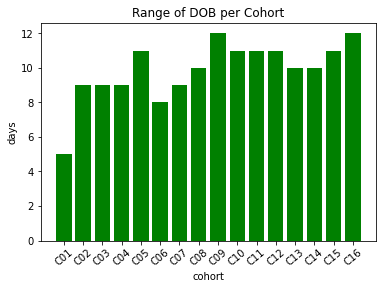

In [13]:
#check the range of data of births per cohort
#Split data based on cohorts
#each cohort has their own df named after their cohort. Ex. C07
def birth_range():
    cohorts = data.cohort.unique()
    for i in cohorts:
        a = data[data.cohort == i]
        globals()[f"{i}"] = a

    #Check that the dob for each cohort is within a certain range
    #right now just outputs the cohort with the day span
    cohorts = data.cohort.unique()
    dob_range = {}
    for i in cohorts:
        globals()[f"dates_{i}"] = globals()[f"{i}"].dob.unique()
        youngest = min(globals()[f"dates_{i}"])
        oldest = max(globals()[f"dates_{i}"])
        difference = oldest - youngest
        dob_range[i] = difference
        print(i,youngest,oldest, difference)


    dates = list(dob_range.values())
    keys = list(dob_range.keys())
    values = []
    dates_1 = []
    for date in dates:
        values.append(date.days)
    res = dict(zip(keys, values))
    dob_range
    sorted_dict = {k: res[k] for k in sorted(res)}
    plt.bar(sorted_dict.keys(), sorted_dict.values(), color='g')
    plt.title('Range of DOB per Cohort')
    plt.xlabel('cohort')
    plt.ylabel('days')
    plt.xticks(rotation = 40)   
    plt.show() 
birth_range()
#dates

In [14]:
#fix errors from above 
#error: david_dietz mislabeled date 
def update_datetime():
    table_name = "p50_david_dietz_2020.wfu_master"
    update = ['dob'] 
    query = "UPDATE " + table_name
    query = query + " SET dob = '2020-12-31'"
    query = query + " WHERE dob = '2021-12-31' AND cohort = 'C05'"
    print(query)
    runQuery(query)


#update_datetime()


In [15]:
# Fixing coatcolor in sample_metadata
def coat_color(data):
    toFix = []
    metadata = data
    print("Before Coat Color Normalization:")
    display(data['coatcolor'].value_counts())

    # metadata = select_wfu_master("u01_olivier_george_oxycodone")
    i_coatcolor = list(metadata.columns).index("coatcolor")
    for index, row in metadata.iterrows():
        coatcolor = data.iloc[index, i_coatcolor]
        if coatcolor == "BLK HOOD":
            coatcolor = "BLACKHOOD"
        elif coatcolor == "BRN HOOD":
            coatcolor = "BROWNHOOD"
        elif coatcolor == "BEN HOOD":
            coatcolor = "BROWNHOOD"
        elif coatcolor == "ALIBINO":
            coatcolor = "ALBINO"
        coatcolor = coatcolor.replace(" ", "")
        if coatcolor != metadata.iloc[index, i_coatcolor]:
            toFix.append(index)
            metadata.iloc[index, i_coatcolor] = coatcolor
    metadata = metadata.iloc[toFix, :]
    metadata.index = range(metadata.shape[0])
    print("After Coat Color Normalization:")
    display(data['coatcolor'].value_counts())

#     if len(metadata.index) > 0:
#         print("Need to normalize following rows for coat color:")
#         display(metadata)
coat_color(data)

Before Coat Color Normalization:


BROWNHOOD    145
BLACK        144
BLACKHOOD    143
ALBINO       109
BROWN         99
Name: coatcolor, dtype: int64

After Coat Color Normalization:


BROWNHOOD    145
BLACK        144
BLACKHOOD    143
ALBINO       109
BROWN         99
Name: coatcolor, dtype: int64

In [16]:
#fix errors above in database
#david dietz errors corrected
def update_coatcolor():
    table_name = "p50_hao_chen_2020.wfu_master"
    update = ['dob']
    wrong_colors = ['BRN HOOD','BLK HOOD','BLACK HOOD','BLACK ',"ALIBINO"]
    right_colors = ['BROWNHOOD','BLACKHOOD',"BLACKHOOD",'BLACK','ALBINO']
    color = dict(zip(wrong_colors, right_colors))
    for key,value in color.items():
        query = "UPDATE " + table_name
        query = query + " SET coatcolor = '" + value + "'"
        query = query + " WHERE coatcolor = '" + key + "'"
        #print(query)
        runQuery(query)
#update_coatcolor()

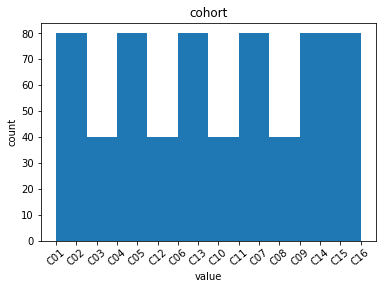

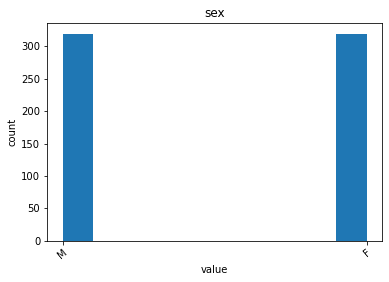

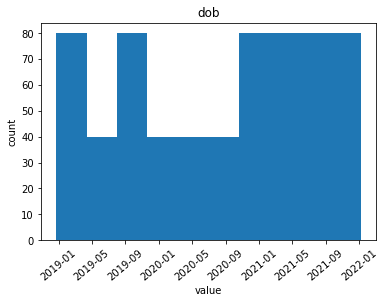

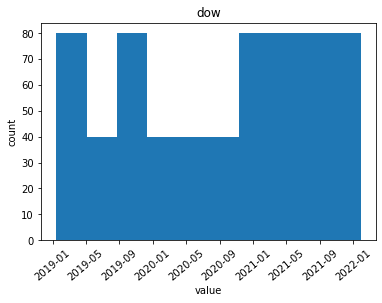

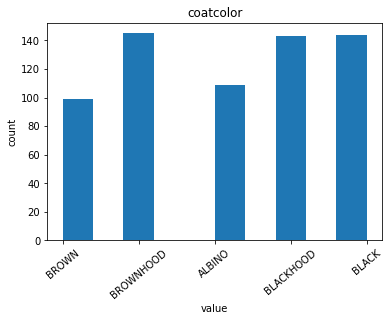

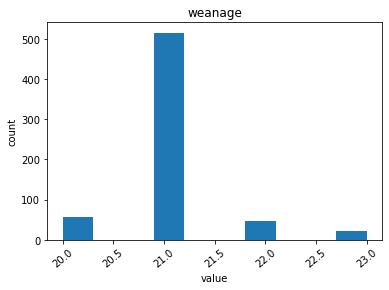

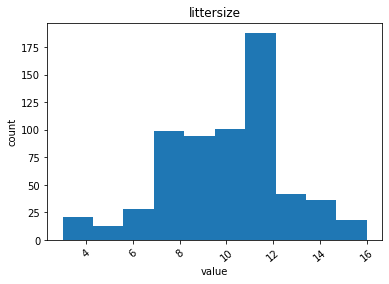

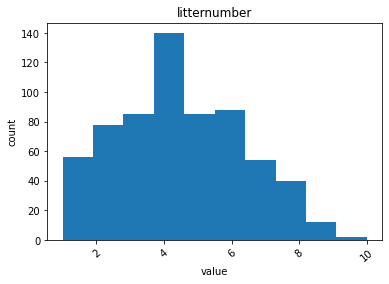

In [17]:
graph_columns = ['cohort','sex','dob','dow','coatcolor','weanage','littersize','litternumber']
for col in graph_columns:
    plt.title(col)
    plt.xlabel('value')
    plt.ylabel('count')
    plt.xticks(rotation = 40)
    plt.hist(data[col].dropna())
    plt.show() 

In [18]:
def qc_rfid(rfid, prefix, length):
    # Checking if prefix is present
    if rfid[:len(prefix)] != prefix:
        return False
    # Checking is rfid is correct length
    elif len(rfid) != length:
        return False
    return True

In [19]:
#Check to make sure rfid for the project contains the correct naming convention
# project_metadata = pd.read_csv("project_metadata - project_metadata.csv", dtype = str)
# i_convention = list(project_metadata.columns).index("rfid_convention")
# for project in projects:
#     print(project)
#     data = runQuery("SELECT * FROM " + project + ".wfu_master")
#     subset = project_metadata[project_metadata["project_name"] == project]
#     subset.index = range(subset.shape[0])
#     convention_list = subset.iloc[0, i_convention]
#     if isinstance(convention_list, float):
#         continue
#     convention_list = convention_list.split(";")
#     for i in range(len(convention_list)):
#         convention_list[i] = convention_list[i].replace("(", "").replace(")", "").split(",")
#     for rfid in data["rfid"]:#data needs to be combination of all projec
#         passed = False
#         for convention in convention_list:
#             prefix = convention[0]
#             length = int(convention[1])
#             passed = passed + qc_rfid(rfid, prefix, length)
#         if not passed:
#             print(rfid, project)
#all issues for current project list are resolved

In [20]:
#data.to_csv(r'C:\Users\cocoy\Dropbox (Palmer Lab)\Palmer Lab\Shae Ziegler\Suzanne_Mitchell_U01\wfu_master.csv', index=False)

In [21]:
data.litternumber.value_counts()

4.0     140
6.0      88
5.0      85
3.0      85
2.0      78
1.0      56
7.0      54
8.0      40
9.0      12
10.0      2
Name: litternumber, dtype: int64